In [1]:
import dask.dataframe as dd
import  pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import time
import gc 


In [2]:
start_time = time.time()
train= pd.read_csv('/home/carlchao/Riiid/data/train.csv',
                usecols=[1, 2, 3,4,7,8,9], dtype={'timestamp': 'int64', 'user_id': 'int32' ,'content_id': 'int16','content_type_id': 'int8','answered_correctly':'int8','prior_question_elapsed_time': 'float32','prior_question_had_explanation': 'int8'})
# train= pd.read_csv('/home/carlchao/Riiid/data/train.csv')
print("pandas took %s seconds" % (time.time() - start_time))
# train = train[train.content_type_id == False]

In [3]:
# !pip install datatable
import datatable as dt
start_time = time.time()
train = dt.fread('/home/carlchao/Riiid_data/data/train.csv')
train = train.to_pandas()
print("datatable took %s seconds" % (time.time() - start_time))



datatable took 5.708926200866699 seconds


In [4]:
train = train.sort_values(['timestamp'], ascending=True)

train.drop(['timestamp','content_type_id'], axis=1,   inplace=True)

results_c = train[['content_id','answered_correctly']].groupby(['content_id']).agg(['mean'])
results_c.columns = ["answered_correctly_content"]

results_u = train[['user_id','answered_correctly']].groupby(['user_id']).agg(['mean', 'sum'])
results_u.columns = ["answered_correctly_user", 'sum']

In [5]:
#reading in question df
questions_df = pd.read_csv('/home/carlchao/Riiid_data/data/questions.csv',
                            usecols=[0,1, 3,4],
                            dtype={'question_id': 'int16',
                              'part': 'int8','bundle_id': 'int8','tags': 'str'}
                          )
tag = questions_df["tags"].str.split(" ", n = 10, expand = True) 
tag.columns = ['tags1','tags2','tags3','tags4','tags5','tags6']

questions_df =  pd.concat([questions_df,tag],axis=1)
questions_df['tags1'] = pd.to_numeric(questions_df['tags1'], errors='coerce')
questions_df['tags2'] = pd.to_numeric(questions_df['tags2'], errors='coerce')
questions_df['tags3'] = pd.to_numeric(questions_df['tags3'], errors='coerce')
questions_df['tags4'] = pd.to_numeric(questions_df['tags4'], errors='coerce')
questions_df['tags5'] = pd.to_numeric(questions_df['tags5'], errors='coerce')
questions_df['tags6'] = pd.to_numeric(questions_df['tags6'], errors='coerce')

In [6]:
X = train.iloc[80000000:,:].copy()
X['prior_question_had_explanation'].fillna(False, inplace=True)
X = pd.merge(X, results_u, on=['user_id'], how="left")
X = pd.merge(X, results_c, on=['content_id'], how="left")
X = pd.merge(X, questions_df, left_on = 'content_id', right_on = 'question_id', how = 'left')

X=X[X.answered_correctly!= -1 ]
X=X.sort_values(['user_id'])
Y = X[["answered_correctly"]]
X = X.drop(["answered_correctly"], axis=1)

In [7]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()
X["prior_question_had_explanation_enc"] = lb_make.fit_transform(X["prior_question_had_explanation"])
X.head()

X = X[['answered_correctly_user', 'answered_correctly_content', 'sum','bundle_id','part','prior_question_elapsed_time','prior_question_had_explanation_enc','tags1','tags2','tags3']] 
X.fillna(0.5,  inplace=True)
from  sklearn.tree import DecisionTreeClassifier
from  sklearn.model_selection import train_test_split
Xt, Xv, Yt, Yv = train_test_split(X, Y, test_size =0.2, shuffle=False)

import lightgbm as lgb

params = {
    'objective': 'binary',
    'max_bin': 600,
    'learning_rate': 0.02,
    'num_leaves': 80
}


lgb_train = lgb.Dataset(Xt, Yt,categorical_feature = ['part','tags1','tags2','tags3'])
lgb_eval = lgb.Dataset(Xv, Yv, reference=lgb_train,categorical_feature = ['part','tags1','tags2','tags3'])

model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=10,
    num_boost_round=10000,
    early_stopping_rounds=10,
    categorical_feature = ['part','tags1','tags2','tags3']
)

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.6	valid_1's binary_logloss: 0.599961
[20]	training's binary_logloss: 0.58142	valid_1's binary_logloss: 0.581288
[30]	training's binary_logloss: 0.568486	valid_1's binary_logloss: 0.568279
[40]	training's binary_logloss: 0.559346	valid_1's binary_logloss: 0.55907
[50]	training's binary_logloss: 0.552807	valid_1's binary_logloss: 0.552471
[60]	training's binary_logloss: 0.548089	valid_1's binary_logloss: 0.547697
[70]	training's binary_logloss: 0.544662	valid_1's binary_logloss: 0.544223
[80]	training's binary_logloss: 0.542152	valid_1's binary_logloss: 0.541681
[90]	training's binary_logloss: 0.54031	valid_1's binary_logloss: 0.53982
[100]	training's binary_logloss: 0.538935	valid_1's binary_logloss: 0.538429
[110]	training's binary_logloss: 0.53789	valid_1's binary_logloss: 0.537377
[120]	training's binary_logloss: 0.537094	valid_1's binary_logloss: 0.536574
[130]	training's binary_logloss: 0

In [8]:
y_pred = model.predict(Xv)
y_true = np.array(Yv)
roc_auc_score(y_true, y_pred)

0.7554420285175782

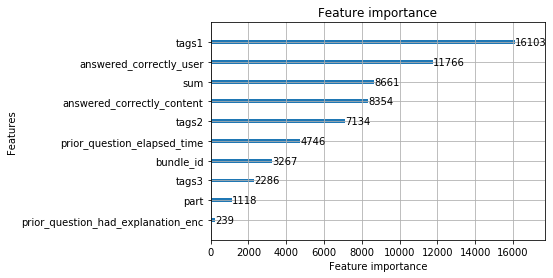

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
#displaying the most important features
lgb.plot_importance(model)
plt.show()

In [10]:
# iter_test = env.iter_test()
# for (test_df, sample_prediction_df) in iter_test:
#     test_df = test_df.sort_values(['user_id','timestamp'], ascending=False)
#     test_df['answer_time'] = test_df.groupby(['user_id'])['prior_question_elapsed_time'].shift(1)
    
#     test_df = pd.merge(test_df, results_u, on=['user_id'],  how="left")
#     test_df = pd.merge(test_df, results_c, on=['content_id'],  how="left")    
#     test_df = pd.merge(test_df, questions_df, left_on = 'content_id', right_on = 'question_id', how = 'left')    
#     test_df['answered_correctly_user'].fillna(0.5, inplace=True)
#     test_df['answered_correctly_content'].fillna(0.5, inplace=True)
#     test_df['sum'].fillna(0, inplace=True)
#     test_df['prior_question_had_explanation'].fillna(False, inplace=True)
#     test_df["prior_question_had_explanation_enc"] = lb_make.fit_transform(test_df["prior_question_had_explanation"])
#     test_df['answered_correctly'] =  model.predict(test_df[['answered_correctly_user', 'answered_correctly_content', 'sum','bundle_id','part','prior_question_elapsed_time','prior_question_had_explanation_enc',
#                                                            'tags1','tags2','tags3']])
#     env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])